In [1]:
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                "bus", "car", "cat", "chair", "cow",
                "diningtable", "dog", "horse", "motorbike", "person",
                "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [2]:
with open("../more_balanced_trainingset_gbr/augmented_balance_images.txt", "r") as fin:
    for i, line in enumerate(fin):
        if i > 5:
            break
        line = line.strip()
        print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
000016.jpg 92 72 305 473 1
000017.jpg 185 62 279 199 14 90 78 403 336 12


In [3]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-11-20 20:46:51.808620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


4 Physical GPUs, 1 Logical GPUs


2023-11-20 20:46:55.264474: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-20 20:46:55.265814: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-20 20:46:55.280380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-20 20:46:55.280765: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2023-11-20 20:46:55.281132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:85:00.0 name: 

In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 16
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = '../more_balanced_trainingset_gbr/augmented_balance_images.txt'
IMAGE_DIR = '../more_balanced_trainingset_gbr/augmented_balance_images/'

DATA_AUG_PATH = '../more_balanced_trainingset_gbr/augmented_balance_images.txt'
IMAGE_AUG_DIR = '../more_balanced_trainingset_gbr/augmented_balance_images/'
# DATA_AUG_PATH = '../DataAugmentationForObjectDetection/augmented_unbalance_images.txt'
# IMAGE_AUG_DIR = '../DataAugmentationForObjectDetection/augmented_unbalance_images/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-5
EPOCHS = 40

In [5]:
import numpy as np

image_name_list = []
record_list = []
object_num_list = []
with open(DATA_PATH, 'r') as fin:
    for line in fin:
        data = line.strip().split()
        image_name_list.append(data[0])
        record = [float(num) for num in data[1:]]
        if len(record) > MAX_OBJECTS_PER_IMAGE * 5:
            record = record[:MAX_OBJECTS_PER_IMAGE * 5]
        record_list.append(record)
        object_num_list.append(len(record) // 5)

bboxes_list = [np.array(record).reshape((-1, 5)) for record in record_list]
name_to_bboxes_dict = dict(zip(image_name_list, bboxes_list))

object_class_list = []
for record in record_list:
    object_class_list.append([int(record[i]) for i in range(4, len(record), 5)])

In [6]:
class_count = np.zeros(NUM_CLASSES, int)
for class_list in object_class_list:
    for c in class_list:
        class_count[c] += 1

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))

 0) aeroplane   1189	 5) bus         1047	10) diningtable  486	15) pottedplant 1911
 1) bicycle     1384	 6) car         1731	11) dog         1693	16) sheep       1308
 2) bird        2160	 7) cat         1397	12) horse        740	17) sofa        1011
 3) boat        1364	 8) chair       1614	13) motorbike    748	18) train       1097
 4) bottle      1551	 9) cow         1252	14) person      6536	19) tvmonitor    953


In [7]:
aug_image_name_list = []
class_count = np.zeros(NUM_CLASSES, int)
total_image_num = len(image_name_list)
image_count = np.zeros(total_image_num, int)

for i in range(total_image_num):
    class_list = object_class_list[i]
    aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
    image_count[i] += 1
    for c in class_list:
        class_count[c] += 1

LOWER_BOUND = 3000
sorted_indices = np.argsort(object_num_list)[::-1]
invalid_aug = np.zeros(total_image_num, int)
while True:
    for i in sorted_indices:
        class_list = object_class_list[i]
        if invalid_aug[i] or (class_count[class_list] >= LOWER_BOUND).any():
            invalid_aug[i] = 1
            continue
        else:
            aug_image_name_list.append(f'{image_count[i]}_{image_name_list[i]}')
            image_count[i] += 1
            for c in class_list:
                class_count[c] += 1
    if (class_count >= LOWER_BOUND).all():
        break

for r in range(5):
    for c in range(NUM_CLASSES // 5):
        i = r + c * 5
        print(f'{i:2d}) {classes_name[i]:11} {class_count[i]:4d}', end=('\n' if c == 3 else '\t'))

 0) aeroplane   3000	 5) bus         3004	10) diningtable 3000	15) pottedplant 3000
 1) bicycle     3000	 6) car         3004	11) dog         3000	16) sheep       3004
 2) bird        3000	 7) cat         3000	12) horse       3000	17) sofa        3000
 3) boat        3001	 8) chair       3003	13) motorbike   3000	18) train       3000
 4) bottle      3001	 9) cow         3000	14) person      6536	19) tvmonitor   3002


In [8]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts image to densenet input
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list
        input_file = open(DATA_AUG_PATH, 'r')

        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])
            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(
                min(len(self.record_list[-1]) // 5, MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE * 5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] + \
                    [0., 0., 0., 0., 0.] * \
                    (MAX_OBJECTS_PER_IMAGE - len(self.record_list[-1]) // 5)

            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE * 5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE * 5]

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_AUG_DIR + image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32)
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.densenet.preprocess_input(image)

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names,
                                                      np.array(self.record_list),
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)\
                         .map(self._data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                         .batch(BATCH_SIZE, drop_remainder=True)\
                         .prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

In [9]:

from tensorflow import keras
from tensorflow.keras import layers
def residual_block(inputs, filters, size, strides):
    x = layers.Conv2D(filters, size, strides, padding="same")(inputs)
    x = layers.LeakyReLU(0.1)(x)
    x = layers.BatchNormalization()(x)
    
    # Create a residual connection
    shortcut = layers.Conv2D(filters, 1, strides, padding="same")(inputs)
    shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.add([x, shortcut])  # Add the input to the output (residual connection)
    return x

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.applications.densenet.DenseNet121(include_top=False, weights="imagenet")(img_inputs)

# concatenate x and img_inputs
x = residual_block(x, 1024, 3, 1)
x = residual_block(x, 1024, 3, 2)
x = residual_block(x, 1024, 3, 1)
x = residual_block(x, 1024, 3, 1)

x = layers.Flatten()(x)
x = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
x = layers.LeakyReLU(0.1)(x)
outputs = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")
YOLO.summary()

Model: "YOLO"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, None, None, 1 7037504     input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 1024) 9438208     densenet121[0][0]                
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 14, 14, 1024) 0           conv2d[0][0]                     
_______________________________________________________________________________________________

In [10]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x,
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 = tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                       boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    # calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    # calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    # intersection
    intersection = rd - lu

    # the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    # if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    # calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)


def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label :  [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    # Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    # turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)

    # calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    # Step B. calculate the coordination of object center and the corresponding mask
    # turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    # calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1,
                                             center_x, CELL_SIZE - center_x - 1]),
                                   tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    # make mask
    # assert objects_center is not negative
    response = tf.pad(response, objects_center_coord, "CONSTANT")
    
    # Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE,
                                               CELL_SIZE,
                                               BOXES_PER_CELL, 4])
    # cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE / CELL_SIZE,
                                     IMAGE_SIZE, IMAGE_SIZE]

    # if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    # calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    # calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    # replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    # calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    # calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    # calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    # calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    # calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    # class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    # object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    # noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    # coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y) / (IMAGE_SIZE / CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w)) / IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h)) / IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [11]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts:    4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
                     ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels:      3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    # you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])

    return loss / BATCH_SIZE


def yolo_loss_map(predicts, labels, objects_num):
    """parallel the code with tf.map_fn"""

    def get_loss(i):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        loss = 0.
        for j in tf.range(object_num):
            loss = loss + losses_calculation(predict, label[j:j+1, :])
        return loss

    batch_loss = tf.map_fn(fn=get_loss,
                           elems=tf.range(BATCH_SIZE),
                           fn_output_signature=tf.float32)
    return tf.reduce_mean(batch_loss)

In [12]:
dataset = DatasetGenerator().generate()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
train_loss_metric = tf.keras.metrics.Mean(name='loss')
ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)
manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=5,
                                     checkpoint_name='yolo')
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2 * 4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [13]:
# recover from the latest checkpoint
ckpt.restore(manager.latest_checkpoint)

In [42]:
from tqdm import tqdm
from datetime import datetime

print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(tqdm(dataset)):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(
        datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))

2023-11-19 12:41:42.859382, start training.


  0%|          | 0/788 [00:00<?, ?it/s]2023-11-19 12:41:42.903559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-11-19 12:41:42.906637: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000810000 Hz
100%|██████████| 788/788 [07:23<00:00,  1.78it/s]


2023-11-19 12:49:06.363179, Epoch 1: loss 2.56
Saved checkpoint for epoch 38: ./ckpts/YOLO/yolo-38


  3%|▎         | 22/788 [00:12<07:11,  1.78it/s]


KeyboardInterrupt: 

## convert output

In [ ]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-38')

In [44]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]
    
    #choose the most confidence one
    
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [45]:
def multi_process_outputs(outputs, top_k=3, confidence_threshold=0.5):
    """
    Process YOLO outputs into top-k bounding boxes with a confidence threshold
    """
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes

    # Extract top-k indices and confidence scores
    top_k_indices = np.argpartition(P, -top_k, axis=None)[-top_k:]
    top_k_indices = np.unravel_index(top_k_indices, P.shape)

    top_k_confidences = P[top_k_indices]

    # Sort indices based on confidence scores
    sorted_indices = np.argsort(top_k_confidences)[::-1]

    # Initialize lists to store results
    results = []

    for i in range(top_k):
        # Get the i-th top index
        index = top_k_indices[0][sorted_indices[i]], top_k_indices[1][sorted_indices[i]], top_k_indices[2][sorted_indices[i]], top_k_indices[3][sorted_indices[i]]
        
        class_num = index[3]
        confidence = top_k_confidences[i]

        # Check if confidence is above the threshold
        if confidence > confidence_threshold:
            coordinate = np.reshape(coordinate, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4))
            max_coordinate = coordinate[index[0], index[1], index[2], :]
            xcenter = max_coordinate[0]
            ycenter = max_coordinate[1]
            w = max_coordinate[2]
            h = max_coordinate[3]
            xcenter = (index[1] + xcenter) * (IMAGE_SIZE / float(CELL_SIZE))
            ycenter = (index[0] + ycenter) * (IMAGE_SIZE / float(CELL_SIZE))
            w = w * IMAGE_SIZE
            h = h * IMAGE_SIZE
            xmin = xcenter - w / 2.0
            ymin = ycenter - h / 2.0
            xmax = xmin + w
            ymax = ymin + h
            # Append bounding box information to results
            results.append((xmin, ymin, xmax, ymax, class_num, confidence))
    
    return results


<function process_outputs at 0x14de13cf6280>


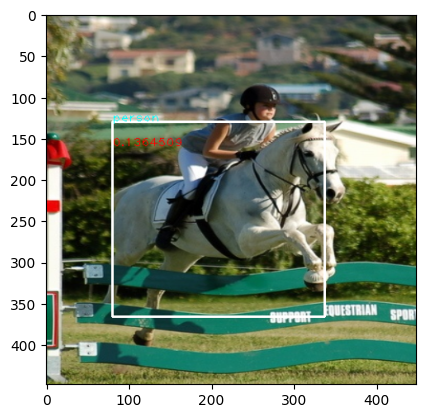

In [46]:
print(process_outputs)

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
np_img = cv2.imread('../2023-datalab-cup2-object-detection//VOCdevkit_test/VOC2007/JPEGImages/009957.jpg')

# 009648.jpg
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
results = multi_process_outputs(y_pred, top_k=3, confidence_threshold=0.1)
for i in range(len(results)):
    xmin, ymin, xmax, ymax, class_num, conf = results[i]
    class_name = classes_name[class_num]
    
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 255, 255), 2)
    cv2.putText(resized_img, class_name, (int(xmin), int(ymin)), 1, 1, (0, 255, 255), 1)
    cv2.putText(resized_img, str(conf), (int(xmin), int(ymin+30)), 1, 1, (255, 0, 0), 1)

plt.imshow(resized_img)
plt.show()

In [47]:
test_img_files = open('../2023-datalab-cup2-object-detection//pascal_voc_testing_data.txt')
test_img_dir = '../2023-datalab-cup2-object-detection//VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [49]:
ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-38')

In [50]:
@tf.function
def prediction_step(img):
    return YOLO(img, training=False)
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs(prediction_step(test_img[i:i+1]))
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))

output_file.close()

In [51]:
import sys
sys.path.insert(0, './evaluate')
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

ModuleNotFoundError: No module named 'evaluate'

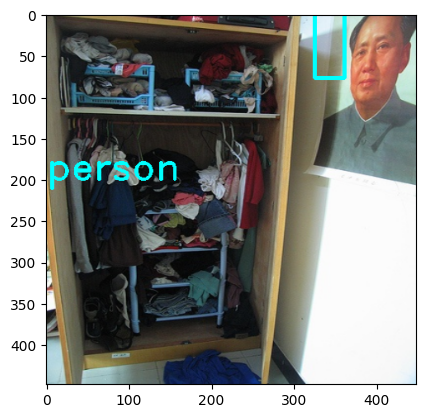

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
np_img = cv2.imread('../2023-datalab-cup2-object-detection//VOCdevkit_test/VOC2007/JPEGImages/009648.jpg')
# 009648.jpg
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs(y_pred)
class_name = classes_name[class_num]
cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)

plt.imshow(resized_img)
plt.show()